# SVM Browser

This notebook takes in a sample of normalized discrete wavelete transform approximation coefficients with corresponding data cleaning labels and outputs a trained SVM model. First, we load modules and files.

In [1]:
# Load modules

import time, pickle, json
import numpy as np
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from matplotlib import cm 
import matplotlib.pyplot as plt
import seaborn as sns

# Set defaults for figures

%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='bright')
plt.style.use('../clint.mpl')

# Load files

with open('../data/hyperparameters.json', 'rb') as infile:
    hyperparams_dict = json.load(infile)
    
with open('../data/p03_r003_train_data.pickle', 'rb') as handle:
    data_dict = pickle.load(handle)

Here we define the training inputs that will go into the SVM.

In [2]:
dwts_norm = data_dict['dwt_norm']
labels = data_dict['dc_label']
SVM_hyperparams = hyperparams_dict['SVM']

Now we train the SVM with the optimal hyperparameters found, and then save the trained model.

In [3]:
svm = SVC(random_state=SVM_hyperparams['random_state'], 
          kernel=SVM_hyperparams['kernel'], 
          decision_function_shape=SVM_hyperparams['decision_function_shape'],
          class_weight=SVM_hyperparams['class_weight'],
          C=SVM_hyperparams['C'],
          gamma=SVM_hyperparams['gamma'])

start_time = time.time()
svm.fit(dwts_norm, labels)
print("--- %s seconds ---" % (time.time() - start_time))

with open("../data/svm.sav", "wb") as svm_file:
    pickle.dump(svm, svm_file)

--- 0.1149132251739502 seconds ---


To visualize how the SVM classifies waveforms into different data cleaning categories, we first embed all waveforms into 2D space using a t-distributed Stochastic Neighbor Embedding (tSNE) algorithm. This should take around 3 minutes.

In [4]:
TSNE_hyperparams = hyperparams_dict['TSNE_2D']

tsne = TSNE(n_components=TSNE_hyperparams['n_components'],
            early_exaggeration=TSNE_hyperparams['early_exaggeration'],
            perplexity=TSNE_hyperparams['perplexity'],
            random_state=TSNE_hyperparams['random_state'],
            learning_rate=TSNE_hyperparams['learning_rate'],
            metric=TSNE_hyperparams['metric'],
            init=TSNE_hyperparams['init'],
            n_jobs=-1)

start_time = time.time()
dwts_norm_2d = tsne.fit_transform(dwts_norm)
print("--- %s minutes elapsed ---" % ((time.time() - start_time)/60))

--- 1.979677681128184 minutes elapsed ---


We have to train a new SVM that can predict labels on the embedded data. For this, we use the default SVM hyperparameters without optimization.

In [5]:
start_time = time.time()
svm_2d = SVC(random_state=SVM_hyperparams['random_state'], 
          kernel=SVM_hyperparams['kernel'], 
          decision_function_shape=SVM_hyperparams['decision_function_shape'],
          class_weight=SVM_hyperparams['class_weight'])
svm_2d.fit(dwts_norm_2d, labels)
print("--- %s seconds elapsed" % (time.time() - start_time))

--- 0.5615575313568115 seconds elapsed


To plot, we create a mesh and a colormap to differentiate between all categories.

In [6]:
from matplotlib.colors import ListedColormap

colors = ['blue', 'green', 'red', 'cyan', 'fuchsia', 
          'gold', 'indigo', 'grey', 'maroon', 'orange',
          'pink', 'yellow', 'sienna', 'purple']
categories = ['Norm', 'NegGo', 'UpSlo', 'DownSlo', 'Spike', 
              'XTalk', 'SlowRise', 'EarlyTr', 'LateTr', 'Saturation',
              'SoftPile', 'HardPile', 'Bump', 'NoiseTr']

cmap = ListedColormap(colors)
cmap_r = cmap.reversed()

num_points = 300
x_min, x_max = dwts_norm_2d[:, 0].min() - 1, dwts_norm_2d[:, 0].max() + 1
y_min, y_max = dwts_norm_2d[:, 1].min() - 1, dwts_norm_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num_points),
                     np.linspace(y_min, y_max, num_points))

Finally, we plot the 2D waveforms and the SVM decision regions.

([], [])

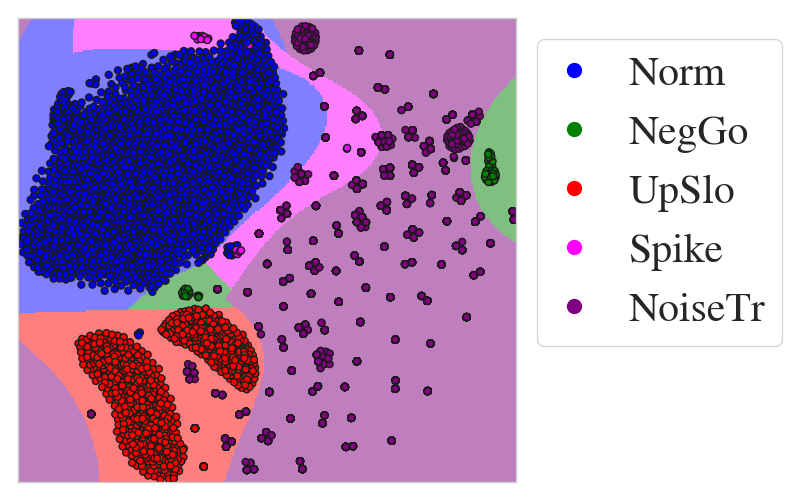

In [7]:
%matplotlib widget 
fig, ax = plt.subplots(1,1)

Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.grid(False)
ax.pcolormesh(xx, yy, -Z, cmap=cmap_r, alpha=0.5)

scatter = ax.scatter(dwts_norm_2d[:, 0], 
                     dwts_norm_2d[:, 1], 
                     c=labels, 
                     cmap=cmap, 
                     edgecolors="k", 
                     marker='.', 
                     label=labels)

handles = scatter.legend_elements()[0]
legend_labels = []

for i in list(set(labels)):
    legend_labels.append(categories[int(i)])
    
ax.legend(handles, legend_labels, fontsize=30, bbox_to_anchor=(1,1))
plt.xticks(())
plt.yticks(())
# plt.savefig('tsne_2d.pdf', format='pdf')